# Import Required Libraries


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import json
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Helper Functions

In [ ]:
# Read the csv data and annotation file

def read_data(data_file=None, label_file=None, key=None):
    with open(label_file) as FI:
        j_label = json.load(FI)
    ano_spans = j_label[key]
    ano_span_count = len(ano_spans)
    df_x = pd.read_csv(data_file)
    df_x, df_y = assign_ano(ano_spans, df_x)

    return df_x, df_y

def assign_ano(ano_spans=None, df_x=None):
    df_x['timestamp'] = pd.to_datetime(df_x['timestamp'])
    y = np.zeros(len(df_x))
    for ano_span in ano_spans:
        ano_start = pd.to_datetime(ano_span[0])
        ano_end = pd.to_datetime(ano_span[1])
        for idx in df_x.index:
            if df_x.loc[idx, 'timestamp'] >= ano_start and df_x.loc[idx, 'timestamp'] <= ano_end:
                y[idx] = 1.0
    return df_x, pd.DataFrame(y)

# create sequences
def unroll(data, labels):
    un_data = []
    un_labels = []
    seq_len = int(window_length)


    idx = 0
    while(idx < len(data) - seq_len):
        un_data.append(np.array(data.iloc[idx:idx+seq_len]))
        un_labels.append(np.array(labels.iloc[idx:idx+seq_len]))
        idx += stride
    return np.array(un_data), np.array(un_labels)

In [ ]:
# Data preprocessing methods


class data(Dataset):
    def __init__(self, x,y):

        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(np.array([1 if sum(y_i) > 0 else 0 for y_i in y])).float()


        self.data_len = x.shape[0]

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
# Anomaly Score Function

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss

    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = netD(x.to(device))
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = netD(G_z.to(device))

    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss

    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

# Variable Initialization

In [ ]:
window_length = 60
stride = 1
batch_size=32
epochs=100
lr=0.0002
device = "cuda"# select the device
seq_len = window_length # sequence length is equal to the window length
in_dim = 1 # input dimension is same as number of feature

# Reading data and Pre-processing

---



In [ ]:
# Reading the annotation file and data

df_x, df_y = read_data('cpu_utilization_asg_misconfiguration.csv', 'combined_windows.json', 'realKnownCause/cpu_utilization_asg_misconfiguration.csv')

In [ ]:
# Dropping the timestamp field

df_x.drop('timestamp', axis=1, inplace=True)

In [ ]:
# Scaling the data

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_x[['value']])
df_x2 = pd.DataFrame(np_scaled)

In [ ]:
x, y = unroll(df_x2, df_y)

In [ ]:
x.shape, y.shape

((17990, 60, 1), (17990, 60, 1))

In [ ]:
dataset = data(x,y)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [ ]:
dataset.x.shape, dataset.y.shape

(torch.Size([17990, 60, 1]), torch.Size([17990]))

# Visualization of Data

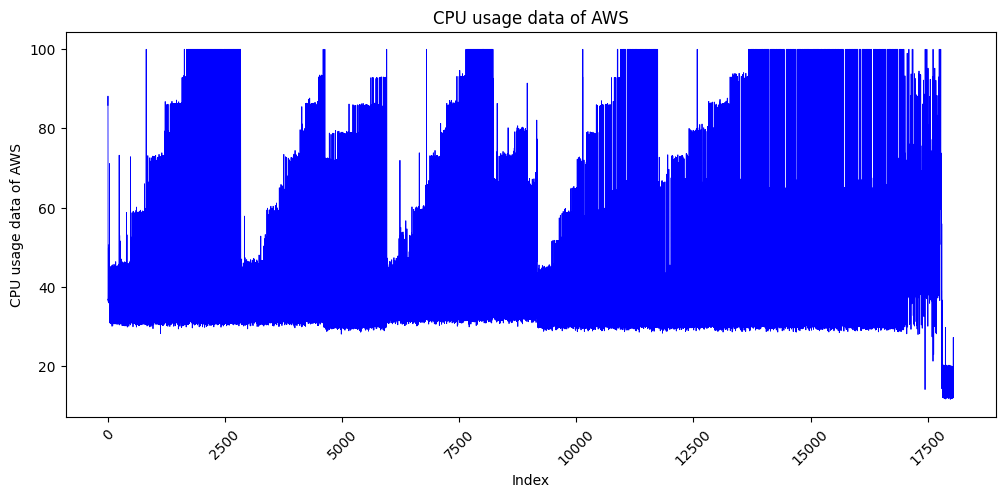

In [ ]:
# change the type of timestamp column for plotting


# Assuming 'df_x' was originally created with a 'timestamp' column
# If 'df_x' was loaded from a file, you'll need to reload it to have the 'timestamp' column

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

# Use df_x.index instead of df_x['timestamp'] for the x-axis
ax.plot(df_x.index, df_x['value'], color='blue', linewidth=0.6)

ax.set_title('CPU usage data of AWS')

plt.xlabel('Index') # Changed x-axis label to 'Index'
plt.xticks(rotation=45)
plt.ylabel('CPU usage data of AWS')
plt.show()

In [ ]:
with open('combined_windows.json') as f:
    j_label = json.load(f)
anom = j_label['realKnownCause/cpu_utilization_asg_misconfiguration.csv']

# Convert anomaly timestamps to pandas Timestamp objects
anom_start = pd.to_datetime(anom[0][0])
anom_end = pd.to_datetime(anom[0][1])

# Find the index corresponding to the anomaly start and

# Generator and Discriminator Functions

In [ ]:
class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """

    def __init__(self, in_dim, out_dim, device=None):
        super().__init__()
        self.out_dim = out_dim
        self.device = device

        self.lstm0 = nn.LSTM(in_dim, hidden_size=32, num_layers=1, batch_first=True)
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)

        self.linear = nn.Sequential(nn.Linear(in_features=128, out_features=out_dim), nn.Tanh())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(1, batch_size, 32).to(self.device)
        c_0 = torch.zeros(1, batch_size, 32).to(self.device)

        recurrent_features, (h_1, c_1) = self.lstm0(input, (h_0, c_0))
        recurrent_features, (h_2, c_2) = self.lstm1(recurrent_features)
        recurrent_features, _ = self.lstm2(recurrent_features)

        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, 128))
        outputs = outputs.view(batch_size, seq_len, self.out_dim)
        return outputs, recurrent_features


class LSTMDiscriminator(nn.Module):
    """An LSTM based discriminator. It expects a sequence as input and outputs a probability for each element.
    Args:
        in_dim: Input noise dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Inputs: sequence of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, 1)
    """

    def __init__(self, in_dim, device=None):
        super().__init__()
        self.device = device

        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(100, 1), nn.Sigmoid())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(1, batch_size, 100).to(self.device)
        c_0 = torch.zeros(1, batch_size, 100).to(self.device)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, 100))
        outputs = outputs.view(batch_size, seq_len, 1)
        return outputs, recurrent_features

In [ ]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)

In [ ]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


# Hyperparameter Definition

In [ ]:
# Setup loss function
criterion = nn.BCELoss().to(device)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

# Adversarial Training of Generator and Discriminator Models

In [ ]:
real_label = 1.
fake_label = 0.

for epoch in range(epochs):
    for i, (x,y) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()

        #Train with fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        label.fill_(real_label)
        output,_ = netD.forward(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()



    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

<ipython-input-24-a46542397a14>:24: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
<ipython-input-24-a46542397a14>:38: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()


[0/100][562/563] Loss_D: 1.3881 Loss_G: 0.5872 D(x): 0.5625 D(G(z)): 0.5560 / 0.5560
[1/100][562/563] Loss_D: 0.9270 Loss_G: 1.1655 D(x): 0.6051 D(G(z)): 0.3305 / 0.3290
[2/100][562/563] Loss_D: 1.1302 Loss_G: 0.7059 D(x): 0.6608 D(G(z)): 0.5006 / 0.5001
[3/100][562/563] Loss_D: 0.3611 Loss_G: 4.1480 D(x): 0.8482 D(G(z)): 0.0788 / 0.0788
[4/100][562/563] Loss_D: 0.9695 Loss_G: 0.7271 D(x): 0.7992 D(G(z)): 0.4895 / 0.4895
[5/100][562/563] Loss_D: 1.6162 Loss_G: 0.3337 D(x): 0.7197 D(G(z)): 0.7213 / 0.7172
[6/100][562/563] Loss_D: 1.4604 Loss_G: 0.4646 D(x): 0.6272 D(G(z)): 0.6289 / 0.6285
[7/100][562/563] Loss_D: 0.4444 Loss_G: 1.5393 D(x): 0.8967 D(G(z)): 0.2502 / 0.2497
[8/100][562/563] Loss_D: 1.4337 Loss_G: 0.4494 D(x): 0.6625 D(G(z)): 0.6388 / 0.6384
[9/100][562/563] Loss_D: 1.5803 Loss_G: 0.4203 D(x): 0.6124 D(G(z)): 0.6575 / 0.6570
[10/100][562/563] Loss_D: 1.4928 Loss_G: 0.4217 D(x): 0.6556 D(G(z)): 0.6566 / 0.6561
[11/100][562/563] Loss_D: 0.4920 Loss_G: 1.4905 D(x): 0.9072 D(G

# Test data Preparation

In [ ]:

stride = window_length

x_test, y_test = unroll(df_x2, df_y)

In [ ]:
x_test.shape, y_test.shape

((300, 60, 1), (300, 60, 1))

In [ ]:
dataset_test = data(x_test,y_test)

In [ ]:
dataset_test.x.shape, dataset_test.y.shape

(torch.Size([300, 60, 1]), torch.Size([300]))

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                         shuffle=False)

# Inverse mapping to latent space and reconstruction of data for estimating anomaly score

In [ ]:
loss_list = []
#y_list = []
for i, (x,y) in enumerate(test_dataloader):
    print(i, y)

    z = Variable(init.normal(torch.zeros(1,
                                     window_length,
                                     1),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=1e-2)

    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = netG(z.cuda())
        loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break

0 tensor([0.])


<ipython-input-30-8a06fe2b34b7>:6: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  z = Variable(init.normal(torch.zeros(1,


~~~~~~~~loss=197.67434692382812,  y=tensor([0.]) ~~~~~~~~~~
1 tensor([0.])
~~~~~~~~loss=214.55384826660156,  y=tensor([0.]) ~~~~~~~~~~
2 tensor([0.])
~~~~~~~~loss=205.31539916992188,  y=tensor([0.]) ~~~~~~~~~~
3 tensor([0.])
~~~~~~~~loss=206.82908630371094,  y=tensor([0.]) ~~~~~~~~~~
4 tensor([0.])
~~~~~~~~loss=191.34280395507812,  y=tensor([0.]) ~~~~~~~~~~
5 tensor([0.])
~~~~~~~~loss=207.76483154296875,  y=tensor([0.]) ~~~~~~~~~~
6 tensor([0.])
~~~~~~~~loss=214.41957092285156,  y=tensor([0.]) ~~~~~~~~~~
7 tensor([0.])
~~~~~~~~loss=210.31764221191406,  y=tensor([0.]) ~~~~~~~~~~
8 tensor([0.])
~~~~~~~~loss=189.11282348632812,  y=tensor([0.]) ~~~~~~~~~~
9 tensor([0.])
~~~~~~~~loss=223.2049102783203,  y=tensor([0.]) ~~~~~~~~~~
10 tensor([0.])
~~~~~~~~loss=206.16665649414062,  y=tensor([0.]) ~~~~~~~~~~
11 tensor([0.])
~~~~~~~~loss=217.7639617919922,  y=tensor([0.]) ~~~~~~~~~~
12 tensor([0.])
~~~~~~~~loss=216.7871551513672,  y=tensor([0.]) ~~~~~~~~~~
13 tensor([0.])
~~~~~~~~loss=229.5821685

In [ ]:
len(loss_list)

300

# Visualise Anomaly Detection

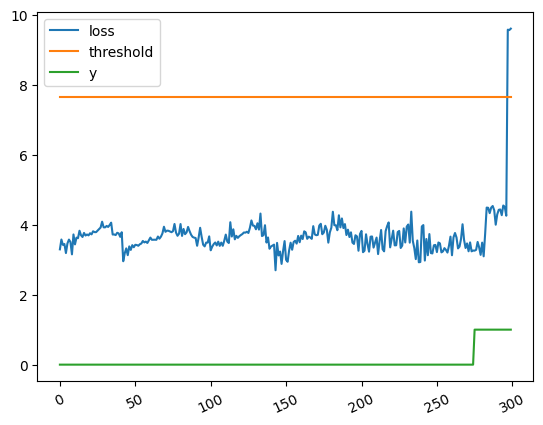

In [ ]:
THRESHOLD = 7.65 # Anomaly score threshold for an instance to be considered as anomaly

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(len(test_dataloader)))
test_score_df['loss'] = [loss.item()/window_length for loss in loss_list]
test_score_df['y'] = dataset_test.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in dataset_test.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend()

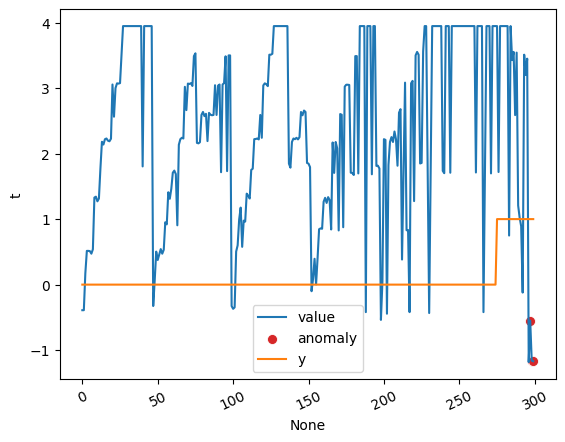

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  range(300),
  test_score_df['t'],
  label='value'
);

# Specify 'x' and 'y' as keyword arguments
sns.scatterplot(
  x=anomalies.index,
  y=anomalies.t,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.plot(
  range(len(test_score_df['y'])),
  test_score_df['y'],
  label='y'
)

plt.xticks(rotation=25)
plt.legend()

# Window-based anomalies Calculation

In [ ]:
#Calculate the window-based anomalies

start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1

actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

# Measurement scores Calculation

In [ ]:
#Calculate measurement scores



predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = (2 * precision * recall) / (precision + recall)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)


True Positive	 3
True Negative	 275
False Positive	 0
False Negative	 22
Accuracy	 0.9266666666666666
Precision	 1.0
Recall	 0.12
f-measure	 0.21428571428571425
cohen_kappa_score	 0.19999999999999996
auc	 0.56
roc_auc	 0.56
